In [1]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Activation, Dense, Dropout, Flatten
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
from time import time
import imutils

Using TensorFlow backend.


In [2]:
# dataset in the data folder
# mixed both good and bad images in the single folder
dataset = 'data'

In [3]:
# getting image paths as list
imagePaths = list(paths.list_images(dataset))

# getting name of class which is basically folder name
classNames = [pt.split(os.path.sep)[-2] for pt in imagePaths]
classNames = [str(x) for x in np.unique(classNames)]

In [4]:
import cv2

# load images
def load(imagePaths):
    # initilize the list of features and labels
    data = []
    labels = []

    # loop over the input images
    for(i, imagePath) in enumerate(imagePaths):
        # load the image and extract the class label
        # assuming that our path has the following format
        image = cv2.imread(imagePath) 
        label = imagePath.split(os.path.sep)[-2]
        
        # interpolation and resize
        inter = cv2.INTER_AREA
        width = 64
        height = 64
        
        (h, w) = image.shape[:2]
        dW = 0
        dH = 0
        
        # resize image with interpolation so that it takes the centre part of the image
        if w < h:
            image = imutils.resize(image, width=width, inter=inter)
            dH = int((image.shape[0] - height) / 2.0)
        
        else:
            image = imutils.resize(image, height=height, inter=inter)
            dH = int((image.shape[0] - height) / 2.0)

        (h, w) = image.shape[:2]
        image = image[dH:h - dH, dW:w - dW]
        image = cv2.resize(image, (width, height), interpolation=inter)
        
        # change image to array
        image = img_to_array(image, data_format=None)

        data.append(image)
        labels.append(label)
    
    # return as numpy array
    return(np.array(data), np.array(labels))

In [5]:
# load and labels
(data, labels) = load(imagePaths)

In [6]:
# Normalize the image
data = data.astype("float") / 255.0

In [7]:
# Split into training and test
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, random_state=42)

In [8]:
# Splitting in training and validation from training set
trainX, valX, trainY, valY   = train_test_split(trainX, trainY, test_size=0.2, random_state=42)

In [9]:
# convert the labels from integers to vectors
trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)
valY = LabelBinarizer().fit_transform(valY)

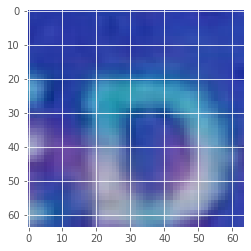

In [21]:
plt.imshow(trainX[100])

In [22]:
trainY[100]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [10]:
# augumeting the image
aug = ImageDataGenerator(rotation_range=30, width_shift_range=0.1,
                            height_shift_range=0.1, zoom_range=0.1,
                            horizontal_flip=True, fill_mode="nearest")

In [11]:
def build_model(width, height, depth, classes):
    # width - width of the input image
    # height - height of the input image OR number of rows
    # depth - number of channels in the input image
    # classes - number of classes
    # initialize the model along with input shape to be 
    # 'channel last'
    model = Sequential()
    inputShape = (height, width, depth)
    # chanDim - the index of the channel dimension
    # channel is depth, whose index is -1
    chanDim = -1 

    # if we are using "channel first", update the input shape
    if K.image_data_format() == "channel_first":
        inputShape = (depth, height, width)
        chanDim = 1

    # first CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(32, (3, 3), padding="same", strides=(2, 2), input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(32, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # secons CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(64, (3, 3), strides=(2, 2), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(64, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    # third CONV => RELU => CONV => RELU => POOL layer set
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(Conv2D(128, (3, 3), padding="same"))
    model.add(Activation("relu"))
    model.add(BatchNormalization(axis=chanDim))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(128))
    model.add(Activation("relu"))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    return model

In [12]:
# initialize the optimizer and model
opt = SGD(lr=0.01, decay=0.01/40, momentum=0.9, nesterov=True)

# build the model
model = build_model(width=64, height=64, depth=3, classes=len(classNames))

# commpile the model
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

W0223 17:06:05.520396  9952 deprecation_wrapper.py:119] From C:\Users\Vedansh\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:4070: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



In [13]:
# train the network on training the data and validation data
H = model.fit_generator(aug.flow(trainX, trainY, batch_size=32),
                        validation_data=(valX, valY), steps_per_epoch=len(trainX) // 32,
                        epochs=100, verbose=1)

W0223 17:06:07.965049  9952 deprecation_wrapper.py:119] From C:\Users\Vedansh\Anaconda3\envs\tensorflow\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/100
251/251 [==============================] - 22s 89ms/step - loss: 3.8826 - accuracy: 0.0970 - val_loss: 3.1656 - val_accuracy: 0.2245
Epoch 2/100
251/251 [==============================] - 16s 62ms/step - loss: 3.0485 - accuracy: 0.2367 - val_loss: 2.4697 - val_accuracy: 0.3659
Epoch 3/100
251/251 [==============================] - 15s 59ms/step - loss: 2.6096 - accuracy: 0.3152 - val_loss: 2.0710 - val_accuracy: 0.4321
Epoch 4/100
251/251 [==============================] - 16s 64ms/step - loss: 2.3063 - accuracy: 0.3872 - val_loss: 1.8546 - val_accuracy: 0.4938
Epoch 5/100
251/251 [==============================] - 18s 71ms/step - loss: 2.1179 - accuracy: 0.4217 - val_loss: 1.7063 - val_accuracy: 0.5291
Epoch 6/100
251/251 [==============================] - 13s 52ms/step - loss: 1.9546 - accuracy: 0.4675 - val_loss: 1.6069 - val_accuracy: 0.5610
Epoch 7/100
251/251 [==============================] - 10s 39ms/step - loss: 1.8493 - accuracy: 0.4844 - val_loss: 1.5089 - val_ac

In [14]:
# evaluation using keras
results = model.evaluate(testX, testY, batch_size=32)
print(model.metrics_names)
print(results)

2511/2511 [==============================] - 2s 870us/step
['loss', 'accuracy']
[1.0733314292310292, 0.7188371419906616]


In [15]:
# evaluate the network for each classes
predictY = model.predict(testX)
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
predictions.argmax(axis=1), target_names=classNames))

              precision    recall  f1-score   support

   Sample001       0.53      0.60      0.56        42
   Sample002       0.69      0.45      0.55        20
   Sample003       0.75      0.68      0.71        22
   Sample004       0.95      0.95      0.95        20
   Sample005       0.73      0.85      0.79        13
   Sample006       0.93      0.88      0.90        16
   Sample007       0.91      0.71      0.80        14
   Sample008       0.85      0.73      0.79        15
   Sample009       1.00      0.38      0.55         8
   Sample010       0.71      0.42      0.53        12
   Sample011       0.95      0.94      0.95       195
   Sample012       0.64      0.86      0.74        29
   Sample013       0.70      0.80      0.75        66
   Sample014       0.72      0.71      0.72        77
   Sample015       0.79      0.85      0.82       141
   Sample016       0.82      0.47      0.60        30
   Sample017       0.76      0.90      0.83        50
   Sample018       0.82    

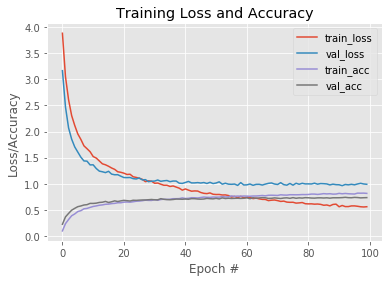

In [16]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

We can easily notice that validation loss is more than training loss. This shows that for the model validation data was easier to predict. The reason is using the dropout as well because usually droupot is activated when training but deactivated while evaluating on validation set. I experimented lots of times without using dropout as well and accuracy was lesser.
While the training accuracy and validation accuracy are almost same.

In [23]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
predy = np.argmax(predictY, axis=1)
cm = confusion_matrix(np.argmax(testY, axis=1), predy)
print(cm)

[[25  0  0 ...  0  0  0]
 [ 0  9  0 ...  0  0  0]
 [ 0  0 15 ...  0  0  0]
 ...
 [ 0  0  0 ...  1  0  0]
 [ 0  0  0 ...  1  5  0]
 [ 0  0  1 ...  0  0  3]]


In [24]:
# taken from 
def plot_confusion_matrix_from_data(y_test, predictions, columns=None, annot=True, cmap="Oranges",
      fmt='.2f', fz=11, lw=0.5, cbar=False, figsize=[8,8], show_null_values=0, pred_val_axis='lin'):
    """
        plot confusion matrix function with y_test (actual values) and predictions (predic),
        whitout a confusion matrix yet
    """
    from sklearn.metrics import confusion_matrix
    from pandas import DataFrame

    #data
    if(not columns):
        #labels axis integer:
        ##columns = range(1, len(np.unique(y_test))+1)
        #labels axis string:
        from string import ascii_uppercase
        columns = ['class %s' %(i) for i in list(ascii_uppercase)[0:len(np.unique(y_test))]]

    confm = confusion_matrix(y_test, predictions)
    cmap = 'Oranges';
    fz = 11;
    figsize=[9,9];
    show_null_values = 2
    df_cm = DataFrame(confm, index=columns, columns=columns)
    pretty_plot_confusion_matrix(df_cm, fz=fz, cmap=cmap, figsize=figsize, show_null_values=show_null_values, pred_val_axis=pred_val_axis)

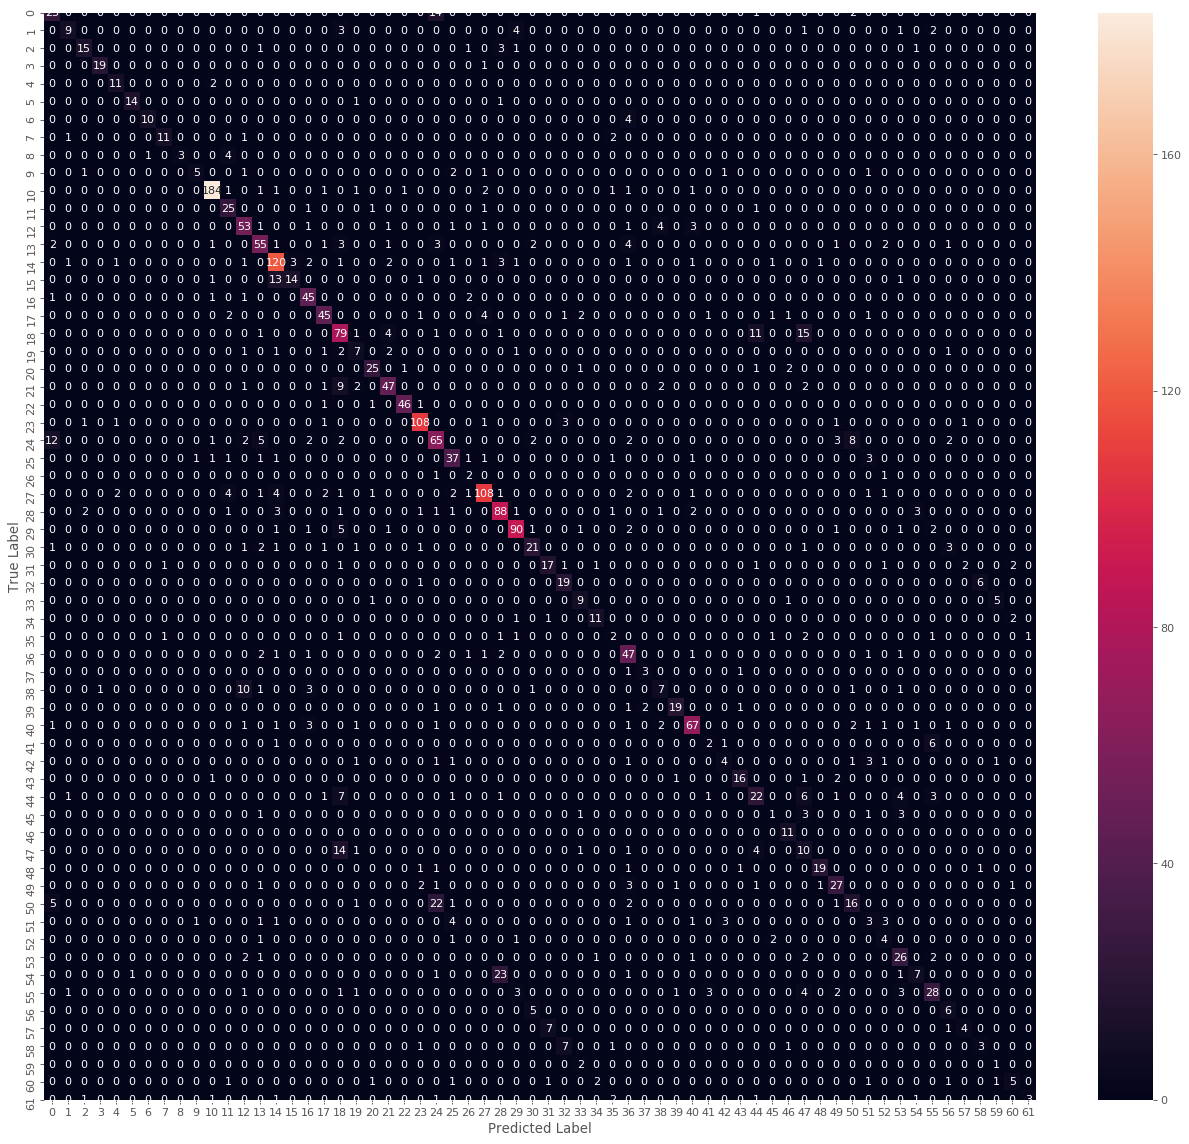

In [25]:
import pandas as pd
import seaborn as sn
#df_cm = pd.DataFrame(cm)
plt.figure(num=None, figsize=(20, 18), dpi=80, facecolor='w', edgecolor='k')
sn.heatmap(cm, annot=True, fmt='d') # font size
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Confusion Matrix shows the count of number of matching of "actual output" label with with "predicted label" from the values. For example if we take row 10 and column 10, we can say that there are 182 true positive, and sum of other element in the same row is false positive, and sum of other element in the same column is false negative and diagonal shows the true negatives.
For sample 60 as well, the number of true positive is 0, as f1-score is 0 as obvious from classification report.

In [26]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)       

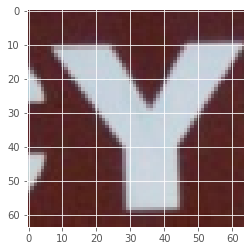

In [37]:
plt.imshow(testX[55])

In [38]:
for layer in model.layers:
    if 'conv' not in layer.name:
        continue
    filters, biases = layer.get_weights()

    print(layer.name, filters.shape)

conv2d_1 (3, 3, 3, 32)
conv2d_2 (3, 3, 32, 32)
conv2d_3 (3, 3, 32, 64)
conv2d_4 (3, 3, 64, 64)
conv2d_5 (3, 3, 64, 128)
conv2d_6 (3, 3, 128, 128)


In [41]:
from keras.models import Model
layer_outputs = [layer.output for layer in model.layers]
activation_model = Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(testX[55].reshape(1,64,64,3))
 
def display_activation(activations, col_size, row_size, act_index): 
    activation = activations[act_index]
    activation_index=0
    plt.figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    fig, ax = plt.subplots(row_size, col_size, figsize=(row_size*2.5,col_size*1.5))
    for row in range(0,row_size):
        for col in range(0,col_size):
            ax[row][col].imshow(activation[0, :, :, activation_index], cmap='gray')
            activation_index += 1

$\textbf{(c)}$

$\textbf{First Convolution layer}$

<Figure size 960x800 with 0 Axes>

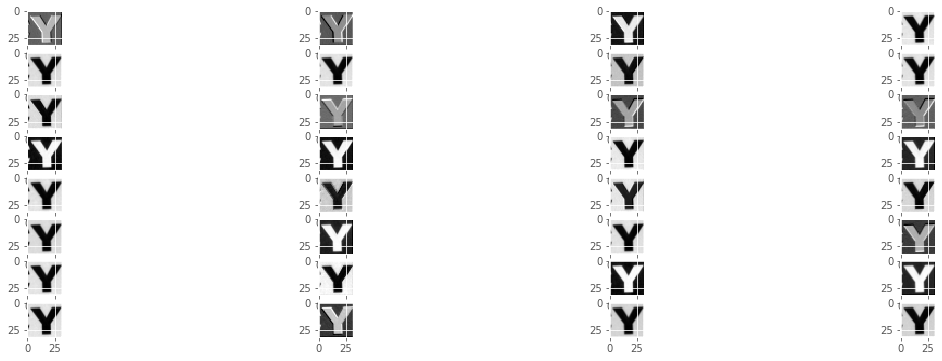

In [42]:
display_activation(activations, 4, 8, 0)

This layer seem to detect some nothing, It just changed the dimension of the image.

$\textbf{Feature maps of first convolution layer}$

<Figure size 960x800 with 0 Axes>

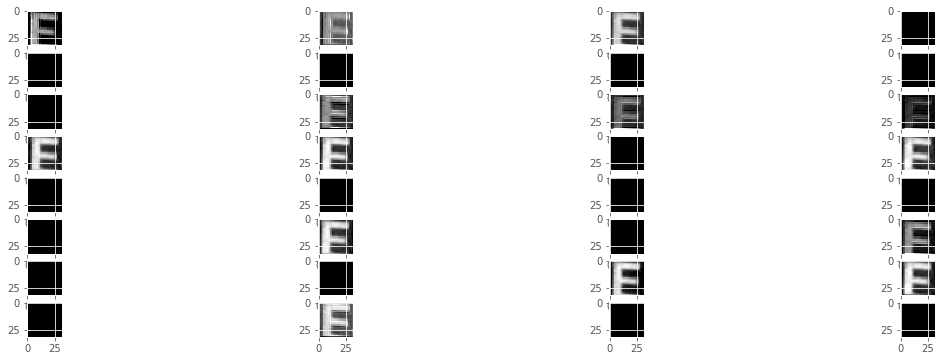

In [33]:
display_activation(activations, 4, 8, 1)

After passing the image from the second layer which is relu, we can clearly see that feature maps are turned black which means that the first layer is not able to detect features.

$\textbf{(d)}$

$\textbf{Second convolutional layer}$

<Figure size 960x800 with 0 Axes>

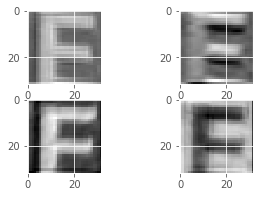

In [34]:
display_activation(activations, 2, 2, 3)

The second convolution layer detects the edges which is shown as black spot as we can see.

$\textbf{Second feature maps}$

In [ ]:
display_activation(activations, 4, 8, 4)

After passing the second convolutional layer from relu, there are less dark images as in the last case, which shows that model is actually detecting the edge of value F.

$\textbf{Third convolutional layer}$

In [ ]:
display_activation(activations, 5, 5, 7)

$\textbf{Third feature maps}$

In [ ]:
display_activation(activations, 5, 5, 8)

Third feature maps clearly shows what the model is detecting by white and grey pixels.

$\textbf{Fourth convolutional layer}$

In [ ]:
display_activation(activations, 5, 5, 10)

$\textbf{Fourth feature maps}$

In [ ]:
display_activation(activations, 5, 5, 11)

$\textbf{Fifth convolution layer}$

<Figure size 960x800 with 0 Axes>

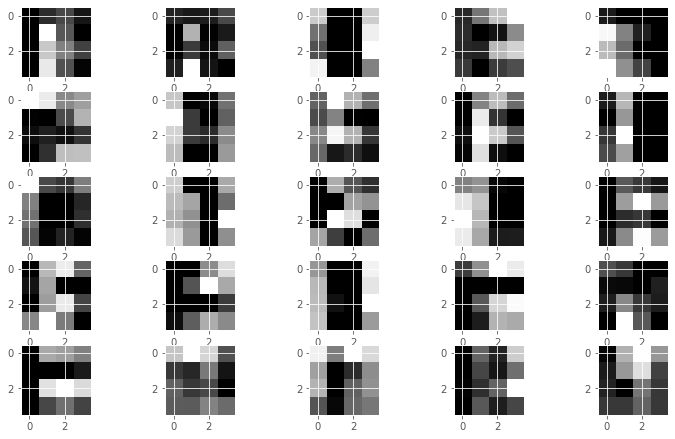

In [35]:
display_activation(activations, 5, 5, 13)

$\textbf{Fifth feature maps}$

<Figure size 960x800 with 0 Axes>

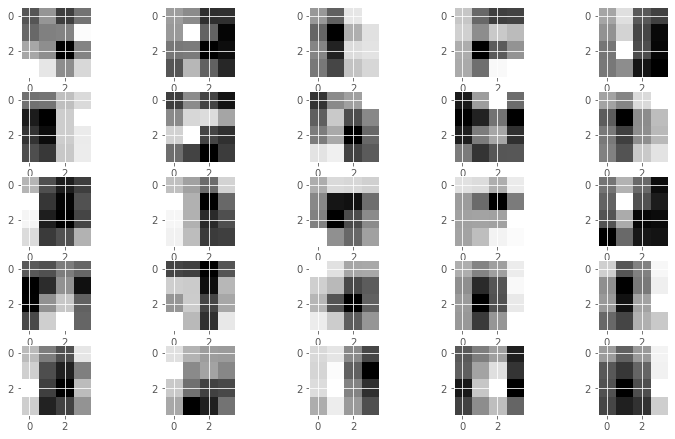

In [36]:
display_activation(activations, 5, 5, 14)

I think it's is almost impossible to conclude something from this, s I think we don't need any more layer.